# Figure S20. Effect of model parameters perturbations on $\langle I_i^E \rangle$ and $\frac{\langle S_i^E \rangle}{\langle S_i^I \rangle}$.

In [1]:
import set_env  # not included in the repo, defines $PROJECT_DIR, $PNC_PROJECT_DIR, $IMAGEN_PROJECT_DIR & $INPUT_DIR

In [2]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

OUTPUT_DIR = {
    "pnc": os.path.join(os.environ["PNC_PROJECT_DIR"], "output"),
    "imagen": os.path.join(os.environ["IMAGEN_PROJECT_DIR"], "output"),
}
INPUT_DIR = os.environ["INPUT_DIR"]
CODE_DIR = os.path.join(os.getcwd(), "..", "scripts")
sys.path.append(CODE_DIR)


import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({"font.size": 12, "font.family": "Asana Math", "figure.dpi": 300})
thcolor = "#44546A"

Load the simulation data that was curated in Figure 2:

In [3]:
try:
    data = pd.read_csv("pnc_data.csv", index_col=0)
except FileNotFoundError as e:
    print("Run Figure 2 first")
    raise(e)

Load perturbed simulations data of 40 randomly selected subjects done via `scripts/modeling/run/cuBNM/perturbation/run_perturbation_all.py`:

In [4]:
data40 = data.sample(n=40, random_state=0)

raw_sim_data = {}
for npz_file in glob('./perturbation/*/it1.npz'):
    alt = npz_file.split('/')[2]
    raw_sim_data[alt] = np.load(npz_file, allow_pickle=True)

pert_raw = {}
pert_stats = []
for sub_i, sub in tqdm(enumerate(data40.index)):
    # in all state average calculations the first 30 seconds (10 TRs) are discarded
    orig_S_ratio = (
        raw_sim_data['orig']['sim_states'].reshape(1)[0]["S_E"][sub_i, 10:].mean(axis=0) /
        raw_sim_data['orig']['sim_states'].reshape(1)[0]["S_I"][sub_i, 10:].mean(axis=0)
    )
    pert_raw[sub] = {}
    pert_raw[sub]['orig'] = {
        'S_ratio': orig_S_ratio,
        'I_E': raw_sim_data['orig']["sim_states"].reshape(1)[0]["I_E"][sub_i, 10:].mean(axis=0)
    }
    for alt_param in ["wEE", "wEI", "wIE", "G"]:
        pert_raw[sub][alt_param] = {}
        for ratio in [0.9, 1.1]:
            k = f"{alt_param}_x{ratio}"
            alt_states = raw_sim_data[k]["sim_states"].reshape(1)[0]
            curr_stats = {
                'sub': sub,
                'alt': alt_param,
                'ratio': ratio,
            }
            pert_raw[sub][alt_param][ratio] = {}
            alt_S_ratio = (
                alt_states["S_E"][sub_i, 10:].mean(axis=0) /
                alt_states["S_I"][sub_i, 10:].mean(axis=0)
            )
            curr_stats['S_ratio_T'] = scipy.stats.ttest_rel(
                alt_S_ratio.round(8), 
                orig_S_ratio.round(8)
            ).statistic
            curr_stats['I_E_T'] = scipy.stats.ttest_rel(
                alt_states["I_E"][sub_i, 10:].mean(axis=0).round(8),
                pert_raw[sub]['orig']['I_E'].round(8)
            ).statistic
            pert_stats.append(curr_stats)
            pert_raw[sub][alt_param][ratio]['S_ratio'] = alt_S_ratio
            pert_raw[sub][alt_param][ratio]['I_E'] = alt_states["I_E"][sub_i, 10:].mean(axis=0)
pert_stats = pd.DataFrame(pert_stats)

40it [01:36,  2.42s/it]


In [9]:
pert_stats[['S_ratio_T', 'I_E_T']].abs().describe().round(3)

,S_ratio_T,I_E_T
count,320.000,320.000
mean,6.994,21.480
std,2.726,5.383
min,2.287,9.580
25%,5.052,17.630
50%,6.694,21.529
75%,8.319,24.513
max,18.699,38.825


## A. Effect of perturbations on optimal simulation of an example subject

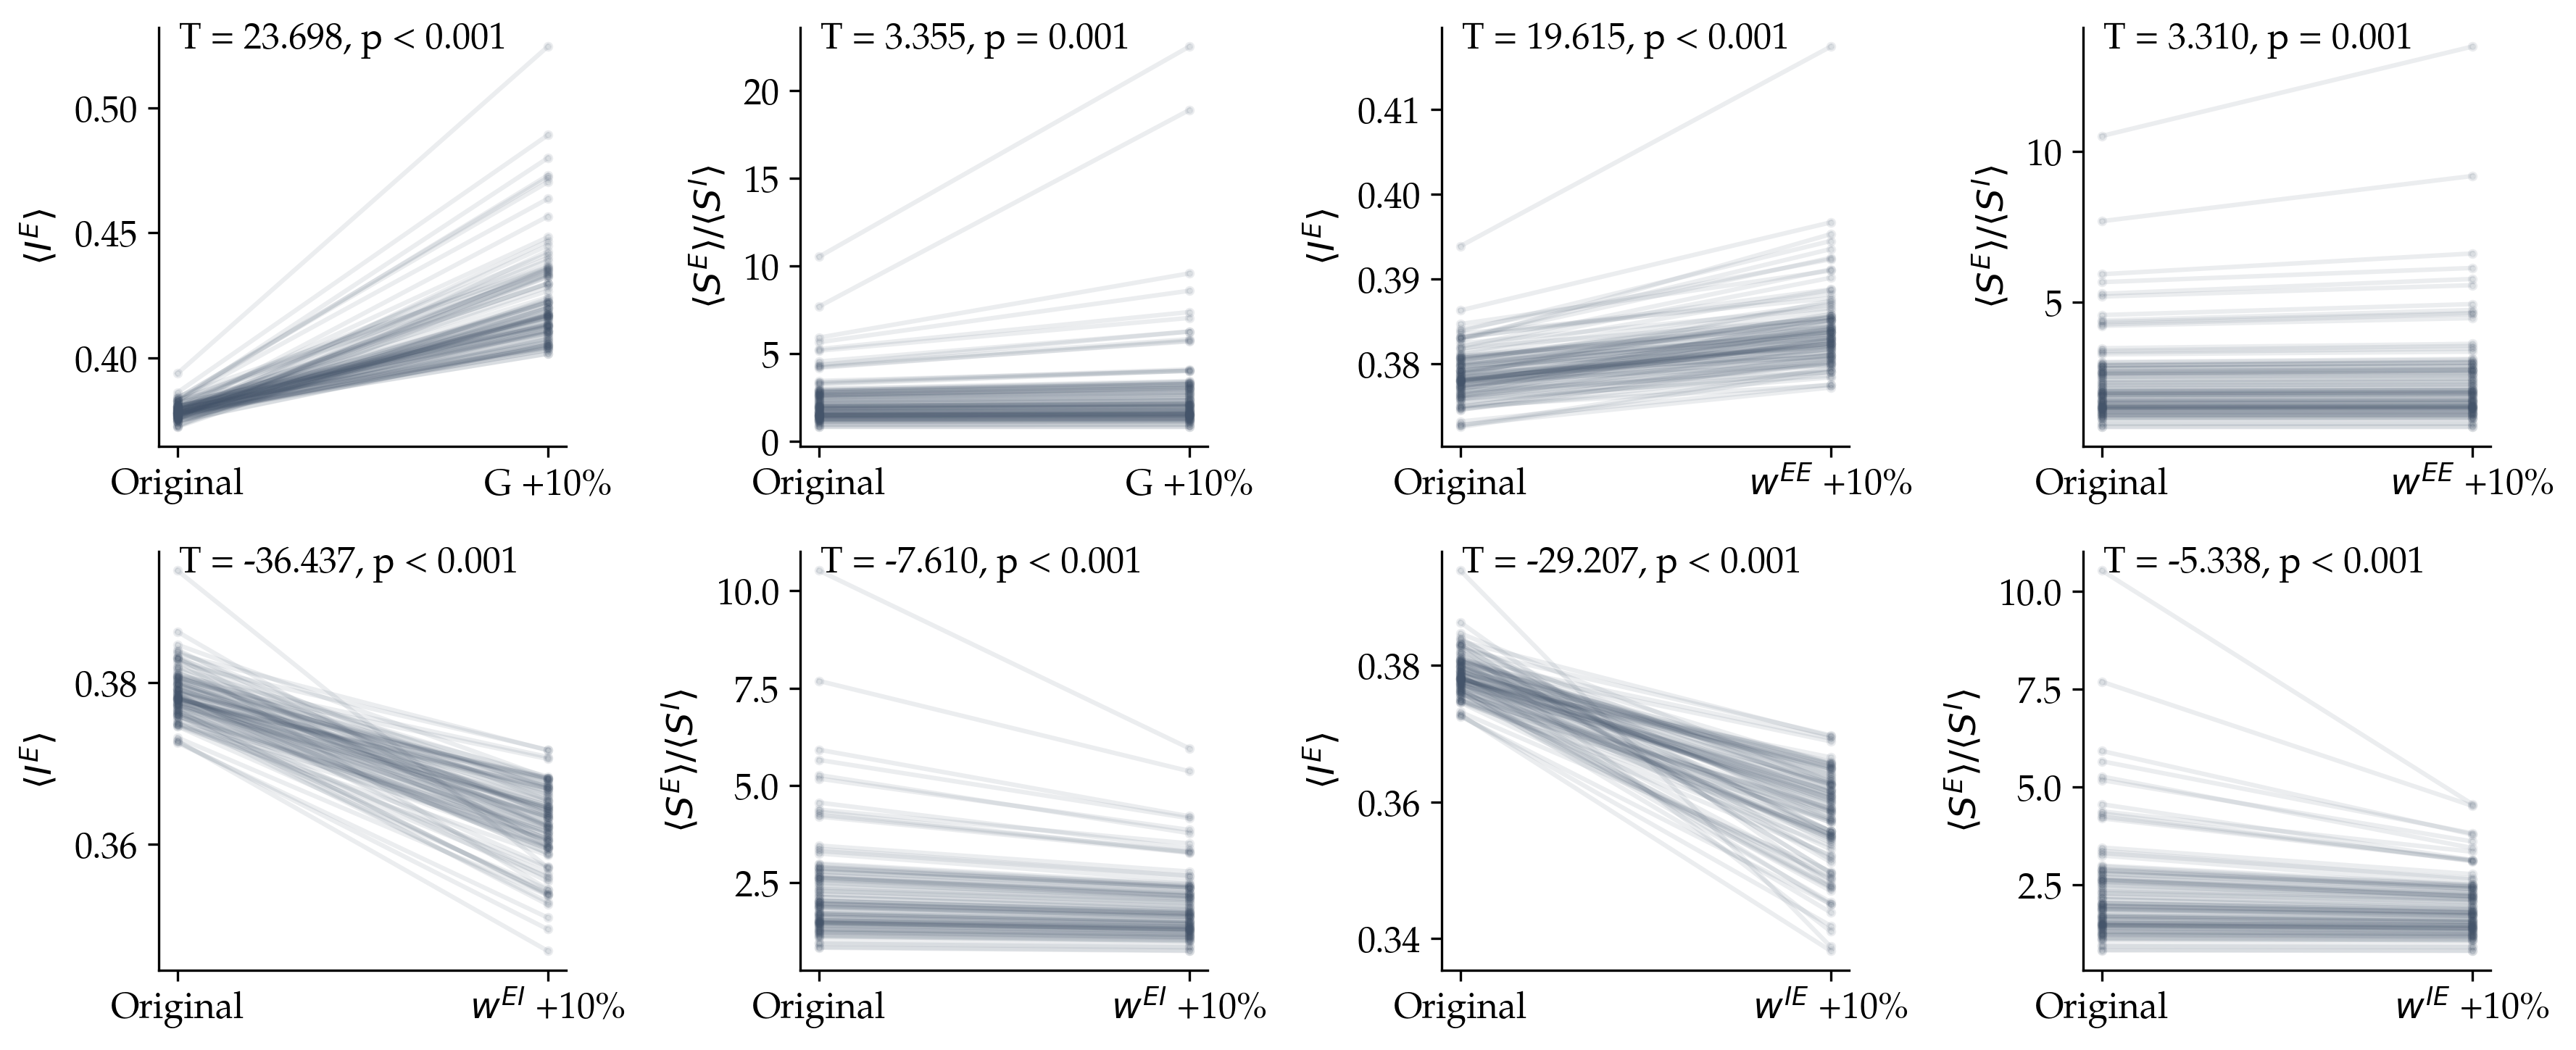

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(12, 5))
axes = axes.flatten()
clean_names = {
    'G': 'G',
    'wEE': r'$w^{EE}$',
    'wEI': r'$w^{EI}$',
    'wIE': r'$w^{IE}$',
    'I_E': r'$\langle I^E \rangle$',
    'S_ratio': r'$\langle S^E \rangle/\langle S^I \rangle$'
}

for i, param in enumerate(['G', 'wEE', 'wEI', 'wIE']):
    for k, measure in enumerate(['I_E', 'S_ratio']):
        ax = axes[i*2+k]
        df = pd.DataFrame({
            'Original': pert_raw[sub]['orig'][measure],
            f'{clean_names[param]} +10%': pert_raw[sub][param][1.1][measure],
        })
        long_df = df.unstack().reset_index()
        ax.scatter(
            long_df["level_0"], long_df[0], color=thcolor, s=5, alpha=0.1
        )
        for node in range(100):
            node_df = long_df.loc[long_df["level_1"] == node]
            ax.plot(
                node_df["level_0"],
                node_df[0],
                color=thcolor,
                alpha=0.1,
            )
        t = scipy.stats.ttest_rel(df.iloc[:,1].round(8), df.iloc[:,0].round(8)).statistic
        p = scipy.stats.ttest_rel(df.iloc[:,1].round(8), df.iloc[:,0].round(8)).pvalue
        text_x = ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.05
        text_y = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95
        text = f'T = {t:.3f}, '
        if p < 0.001:
            text+= 'p < 0.001'
        else:
            text+= f'p = {p:.3f}'
        ax.text(text_x, text_y, text, color="black", multialignment="left")
        ax.set_ylabel(clean_names[measure])
        sns.despine()
fig.tight_layout()

## B. Distribution of perturbtaion effect paired T statistics across all 40 subjects

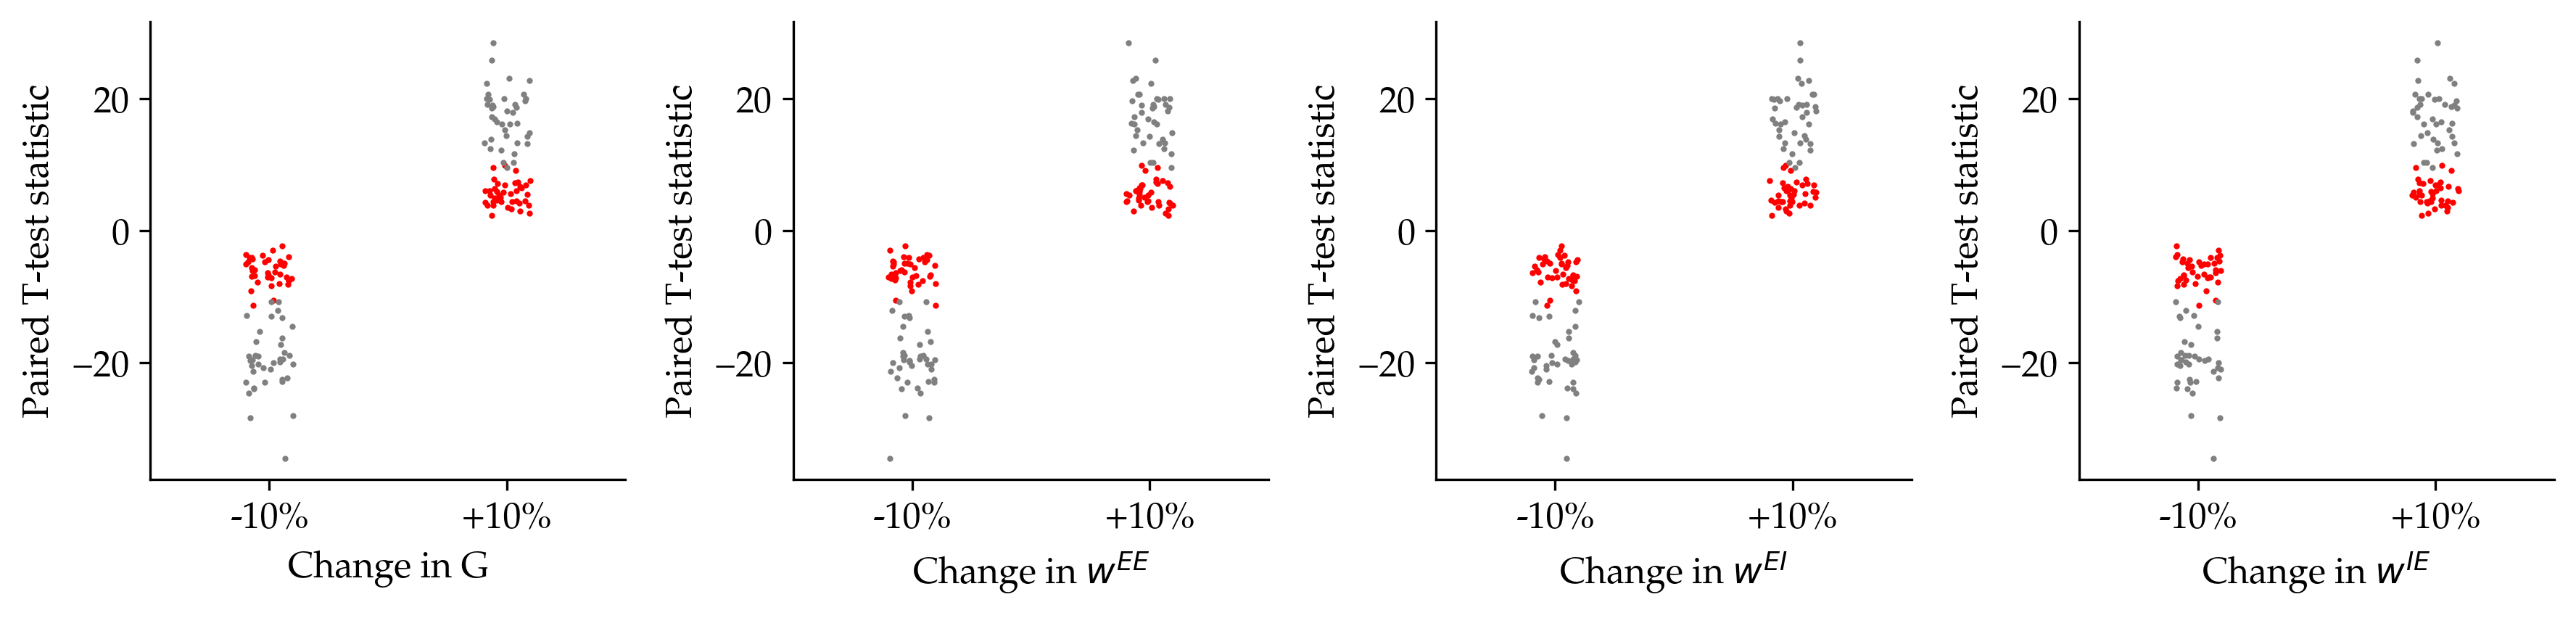

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes = axes.flatten()
for i, param in enumerate(['G', 'wEE', 'wEI', 'wIE']):
    ax = axes[i]
    curr_data = pert_stats.loc[(pert_stats['alt']=='wEE') & (pert_stats['ratio'].isin([0.9, 1.1]))]
    sns.stripplot(data=curr_data, y='S_ratio_T', x='ratio', ax=ax, color='red', size=2)
    sns.stripplot(data=curr_data, y='I_E_T', x='ratio', ax=ax, color='grey', size=2)
    ax.set_xlabel(f'Change in {clean_names[param]}')
    ax.set_xticklabels(['-10%', '+10%'])
    ax.set_ylabel('Paired T-test statistic')
    sns.despine()
fig.tight_layout()

(0.0, 1.0, 0.0, 1.0)

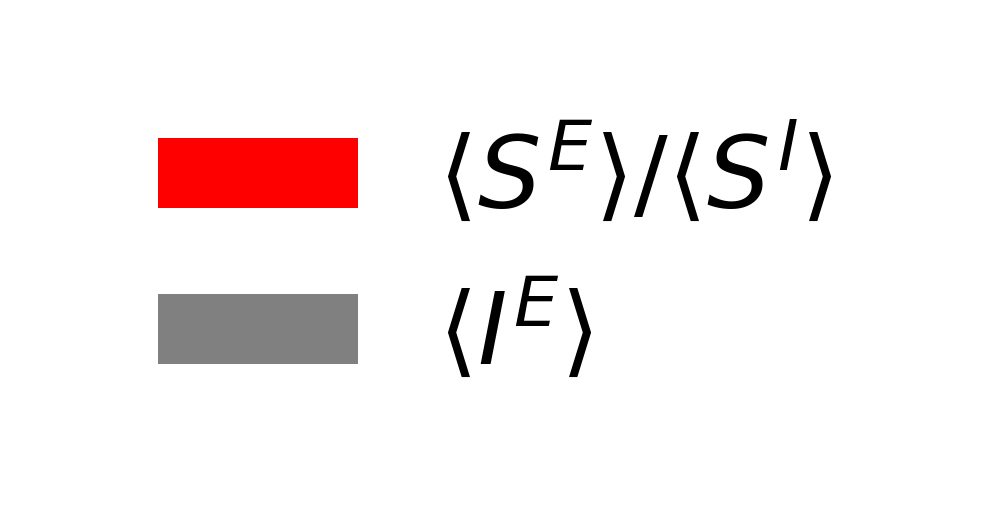

In [12]:
from matplotlib.patches import Patch
colors = {clean_names['S_ratio']: 'red', clean_names['I_E']: 'grey'}
legend_handles = [
    Patch(facecolor=colors[label], edgecolor="none", label=label) for label in colors
]
plt.figure(figsize=(4, 2))
plt.legend(handles=legend_handles, fontsize="24", loc="center", frameon=False)
plt.axis("off")